# Modelling Chondrule Size Distributions

Companion Jupyter Notebook to the paper 'Revealing the relationship between 2D and 3D chondrule size-frequency distribution in a meteorite'

# importing the necessary libaries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from scipy import stats
import numpy as np
import pandas as pd
import random
from IPython.display import clear_output
import os
current_dir = os.getcwd()

# commands

In [2]:
##-------------------------------------------------------------##
##--- Make the 3D Chondrule List ------------------------------##
##-------------------------------------------------------------##

def chd3DList(numberOfChondrules, zAxisLength, mu3D, sigma3D):
    chdList = []

    for i in range(numberOfChondrules):
        chdDiameter = np.random.lognormal(mu3D, sigma3D) # random chd diameter from a log-normal distribution
        chdCenterInter = zAxisLength * random.random() # random z-axis intercept
        chdTopInter = chdCenterInter + .5 * chdDiameter
        chdBottomInter = chdCenterInter - .5 * chdDiameter
        chdList.append([chdDiameter, chdCenterInter, chdTopInter, chdBottomInter])

    dfChdList = pd.DataFrame(chdList)
    return dfChdList.rename(columns = {0:'Chd Diameter', 1:'Chd Center z Intercept' , 2:'Chd Top z Intercept', 3:'Chd Bottom z Intercept'})
    

##---------------------------------------------------------------##
##--- Produce the list of the apparent 2D chondrule diameters ---##
##---------------------------------------------------------------##

def sectionedChd(zAxInter, chdList3D):
    zAxisIntercept = zAxInter
    
    # Select all chd visible at a specific z-axis intercept
    fil = (zAxisIntercept < chdList3D['Chd Top z Intercept']) & (zAxisIntercept > chdList3D['Chd Bottom z Intercept'])
    sectionedChdList = chdList3D[fil]

    # Calculate the diameters of all the sectioned chondrules at a specific zAxisIntercept
    appChdDiameterList = []
    for index, sectChd in sectionedChdList.iterrows():
        appChdDia = 2 * (((.5 * sectChd.iloc[0])**2 - (sectChd.iloc[1] - zAxisIntercept)**2)**.5)
        appChdDiameterList.append(appChdDia)

    return appChdDiameterList


##-------------------------------------------------------------##
##--- Fitting a distribution and calculating its mu & sigma ---##
##-------------------------------------------------------------##

def calcMuSigma(sample):
    shape, loc, scale = stats.lognorm.fit(sample, floc=0) # hold location to 0 while fitting
    m, s = np.log(scale), shape  # mu, sigma
    return (m, s)

# Calculating the results file – this may take quite some time

In [3]:
# the mu of the parent 3D distribution is fixed at a typical value for chondrule size distributions
# taken from the metzler data fits below

mu3DList = [6, 6.2, 6.4, 6.6] # mu3DList = [x/100 for x in range(500,720,25)]
iniSigma_List = [x/100 for x in range(5,105,5)]

numberOfChondrules = 10**6
zAxisLength = 10**5
parameters = []

for maxChdSize in [1000, 1500, 2000, 4000]:
    for mu3D in mu3DList:
        loop_counter = 0
        # the minimum chondrule diameters as well as the sigma of the chondrule size distribution are varied
        for iniSigma in iniSigma_List:
            clear_output(wait=True)
            loop_counter+=1
            print(f'max Chd Size: {maxChdSize}')
            print(f'mu3D: {mu3D}')
            print(f'remaining iniSigma loops:  {len(iniSigma_List)-loop_counter}')
            dfChdList = chd3DList(numberOfChondrules, zAxisLength, mu3D, iniSigma) # noc, zAxisLen, mu, sigma
            
            for minChdSize in range(0, 420, 20):
                filDiameter = (dfChdList['Chd Diameter'] > minChdSize) & (dfChdList['Chd Diameter'] < maxChdSize)
                dfChdList = dfChdList[filDiameter]
                appChdDiameterList = sectionedChd(0.5 * zAxisLength, dfChdList)
    
                muFit3D, SigmaFit3D = calcMuSigma(dfChdList['Chd Diameter'])
                muFit2D, sigmaFit2D = calcMuSigma(appChdDiameterList)
    
                parameters3D = [muFit3D, SigmaFit3D, np.e**(muFit3D + .5 * SigmaFit3D**2), np.e**muFit3D, np.e**(muFit3D - SigmaFit3D**2)]   # 3D: mu, sigma, mean, median, mode
                parameters2D = [muFit2D, sigmaFit2D, np.e**(muFit2D + .5 * sigmaFit2D**2), np.e**muFit2D, np.e**(muFit2D - sigmaFit2D**2)]
                parameters.append([len(appChdDiameterList), minChdSize, maxChdSize, mu3D, iniSigma] + parameters3D + parameters2D)
    
dfParameters = pd.DataFrame(parameters)
dfParameters = dfParameters.rename(columns = {0:'Nr. of Sect. Chd', 1:'min. Chd Diameter', 2:'max. Chd Diameter', 3:r'initial $\mu$ 3D', 4:r'initial $\sigma$ 3D'
                            ,5:r'$\mu$ Fit 3D', 6:r'$\sigma$ Fit 3D', 7:'mean 3D', 8:'median 3D', 9:'mode 3D'
                            ,10:r'$\mu$ Fit 2D', 11:r'$\sigma$ Fit 2D', 12:'mean 2D', 13:'median 2D', 14:'mode 2D'})
dfParameters.to_csv('chondrules 2D-3D distributions results file.csv')

# Progress indicator
clear_output(wait=True)
print('results are ready')

results are ready


# Fig. 3

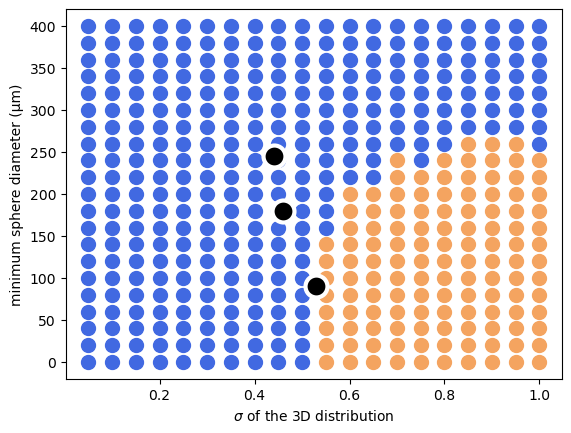

In [4]:
max_chd_size = 1500
sel_mu3D = 6.2

df_results = pd.read_csv(current_dir + '/chondrules 2D-3D distributions results file.csv')
fil = (df_results['max. Chd Diameter'] == max_chd_size) & (df_results['initial $\mu$ 3D'] == sel_mu3D)
dfParameters = df_results[fil]

filBlue = dfParameters['mean 2D'] <= dfParameters['mean 3D']  # 2D < 3D
filOrange = dfParameters['mean 2D'] > dfParameters['mean 3D']  # 2D > 3D

plt.scatter(dfParameters[filBlue][r'initial $\sigma$ 3D'], dfParameters[filBlue]['min. Chd Diameter'], color = 'royalblue', s = 100)
plt.scatter(dfParameters[filOrange][r'initial $\sigma$ 3D'], dfParameters[filOrange]['min. Chd Diameter'], color = 'sandybrown', s = 100)

plt.scatter([.53, .46, .44],[90, 180, 245], color = 'black', edgecolors= 'white', linewidths = 3, s = 250)

plt.xlabel(r'$\sigma$ of the 3D distribution')
plt.ylabel('minimum sphere diameter (µm)')

plt.savefig('Fig. 3.pdf')

plt.show()

# Fig. 4- example of a switch from mean 3D being higher to mean 2D being higher

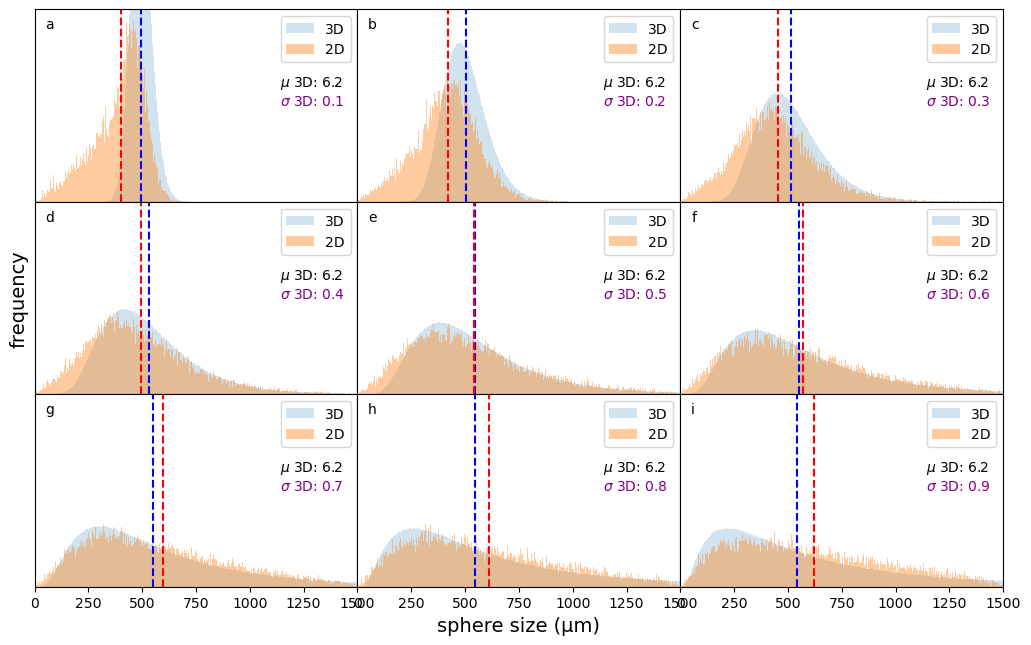

In [5]:
mu3D = 6.2
sigma3Dini = .1
numberOfChondrules = 10**7
zAxisLength = 10**5
maxChdSize = 1500
plot_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize = (12.5, 7.5))
plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0)

z=0
for i in range(3):
    for j in range(3):
# the mu of the parent 3D distribution is fixed at a typical value for chondrule size distributions
#    mu3D = 6.2

# Simple progress counter
#    print(i)
        z+=1
        dfChdList = chd3DList(numberOfChondrules, zAxisLength, mu3D, sigma3Dini * z) # noc, zAxisLen, mu, sigma
        dfChdList = dfChdList[dfChdList['Chd Diameter'] < maxChdSize]
        appChdDiameterList = sectionedChd(.5 * zAxisLength, dfChdList)
        muFit, SigmaFit = calcMuSigma(appChdDiameterList)
        muFit3D, SigmaFit3D = calcMuSigma(dfChdList['Chd Diameter'])
    
        # plotting and formatting the figure
        xAxisMax = maxChdSize
    
        axs[i,j].hist(dfChdList['Chd Diameter'], 1000, density = True, alpha = .2, label = '3D')
        axs[i,j].hist(appChdDiameterList, 1000, density = True, alpha = .4, label = '2D')
        
        
        # ax.set_ylabel('frequency')
        axs[i,j].legend()
        
        axs[i,j].text(.76, .6, r'$\mu$ 3D: ' + str(mu3D), horizontalalignment = 'left', transform = axs[i,j].transAxes)
        axs[i,j].text(.76, .5, r'$\sigma$ 3D: ' + str(round(.1*z, 1)), horizontalalignment = 'left', color = 'purple', transform = axs[i,j].transAxes)
        # axs[i, j].text(0.5, 0.5, 'Text', ha='center', va='center', transform=axs[i, j].transAxes)
        axs[i,j].vlines(np.e**(muFit3D + 0.5 * SigmaFit3D**2), 0, .005, linestyles = 'dashed', colors = 'blue')
        axs[i,j].vlines(np.e**(muFit + 0.5 * SigmaFit**2), 0, .005, linestyles = 'dashed', colors = 'red')
    
        axs[i,j].set_xlim(0, xAxisMax)
        axs[i,j].set_ylim(0, .005)

        axs[i,j].text(50, .0045, plot_labels[z-1])


for j, ax in enumerate(axs[-1]):
    if j == 1:
        ax.set_xlabel('sphere size (µm)', fontsize=14)
    else:
        ax.set_xlabel('')  # Empty string for x-axis label
        
for ax in axs[-1]:
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        if i == 1 and j == 0:
            ax.set_ylabel('frequency', rotation=90, fontsize=14) # or: normalised abundances
            ax.yaxis.set_ticks_position('none')  # Remove ticks
        else:
            ax.set_yticklabels([])  # Remove tick labels
            ax.set_yticks([])  # Remove ticks

plt.savefig('Fig. 4.pdf')

# Fig. 5a

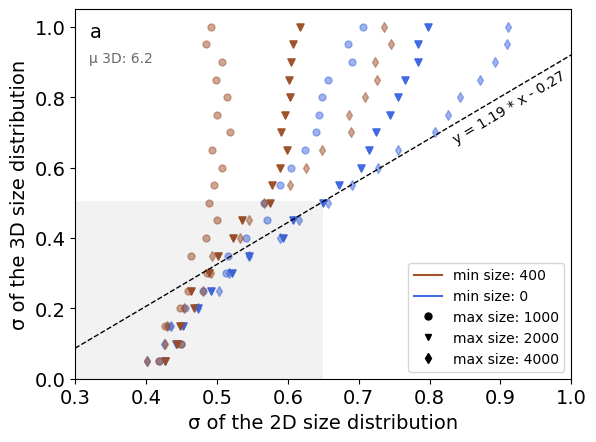

In [6]:
dfPara = pd.read_csv('chondrules 2D-3D distributions results file.csv')
selParam = dfPara.columns.tolist()
xAxis = selParam[12]
yAxis = selParam[5]

plt.text(.32, .97, 'a', fontsize=14)
plt.text(.32, .9, 'µ 3D: 6.2', c='dimgrey')
plt.text(.83, .67, 'y = 1.19 * x - 0.27', rotation=31)

x = np.linspace(0, 1.7, 50)
plt.plot(x, 1.19 * x - .27, color = 'black', linestyle='--', lw = 1)

for mark, maxChdSize in [['o', 1000], ['v', 2000], ['d', 4000]]:
    for mu3D in [6.2]:
        for col, minChdSize in [['royalblue', 0], ['sienna', 400]]:
            fil = (dfPara['min. Chd Diameter'] == minChdSize) & (dfPara['max. Chd Diameter'] == maxChdSize) & (dfPara[r'initial $\mu$ 3D'] == mu3D)
            if maxChdSize == 2000:
                plt.scatter(dfPara[fil][xAxis], dfPara[fil][yAxis], label=minChdSize, marker=mark, s=25, c=col)
            plt.scatter(dfPara[fil][xAxis], dfPara[fil][yAxis], label=minChdSize, marker=mark, s=25, c=col, alpha=.5)

lower_rect = patches.Rectangle((0, 0), 0.65, 1.19 * .65 - .27, facecolor='black', alpha=.05)
plt.gca().add_patch(lower_rect)

plt.xlim(.3, 1)
plt.ylim(0, 1.05)
plt.xlabel('σ of the 2D size distribution', fontsize=14)
plt.ylabel('σ of the 3D size distribution', fontsize=14)
plt.legend(title=r'$\mu$ 3D', loc='lower right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


legend_handles = [
    plt.Line2D([], [], color='sienna', linestyle='-', label='min size: 400'),
    plt.Line2D([], [], color='royalblue', linestyle='-', label='min size: 0'),
    plt.Line2D([], [], color='black', marker='o', linestyle='None', markersize=5, label='max size: 1000'),
    plt.Line2D([], [], color='black', marker='v', linestyle='None', markersize=5, label='max size: 2000'),
    plt.Line2D([], [], color='black', marker='d', linestyle='None', markersize=5, label='max size: 4000')
]

plt.legend(handles=legend_handles) #, title='legend title')
plt.savefig('Fig. 5a.pdf')
plt.show()

# Fig. 5b

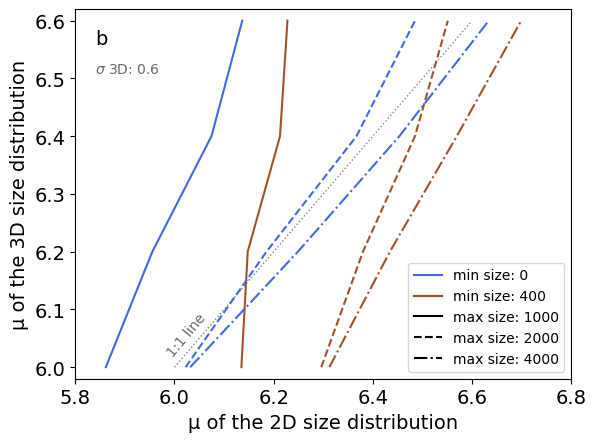

In [7]:
xAxis = selParam[11]
yAxis = selParam[4]

plt.text(5.84, 6.56, 'b', fontsize=14)
plt.text(5.84, 6.51, r'$\sigma$ 3D: 0.6', c='dimgrey')
plt.text(5.98, 6.02, '1:1 line', c='dimgrey', rotation=50)
x = np.linspace(6, 6.6, 50)
plt.plot(x, x, linestyle=':', c='grey', lw = 1)

for sigma in [.6]: #[.02] + [x/10 for x in range(2, 20, 2)] + [1.98]:
    for l_style, maxChdSize in [['-', 1000], ['--', 2000], ['-.', 4000]]:
        for col, minChdSize in [['royalblue', 0], ['sienna', 400]]:
            fil = (dfPara['min. Chd Diameter'] == minChdSize) & (dfPara['max. Chd Diameter'] == maxChdSize) & (dfPara[r'initial $\sigma$ 3D'] == sigma)
            plt.plot(dfPara[fil][xAxis], dfPara[fil][yAxis], linestyle=l_style, color=col, label=sigma)

plt.xlim(5.8, 6.8)
plt.ylim(5.98, 6.62)
plt.xlabel('μ of the 2D size distribution', fontsize=14)
plt.ylabel('μ of the 3D size distribution', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
legend_handles = [
    plt.Line2D([], [], color='royalblue', linestyle='-', label='min size: 0'),
    plt.Line2D([], [], color='sienna', linestyle='-', label='min size: 400'),
    plt.Line2D([], [], color='black', linestyle='-', label='max size: 1000'),
    plt.Line2D([], [], color='black', linestyle='--', label='max size: 2000'),
    plt.Line2D([], [], color='black', linestyle='-.', label='max size: 4000')
]
plt.legend(handles = legend_handles, loc='lower right')
plt.savefig('Fig. 5b.pdf')
plt.show()

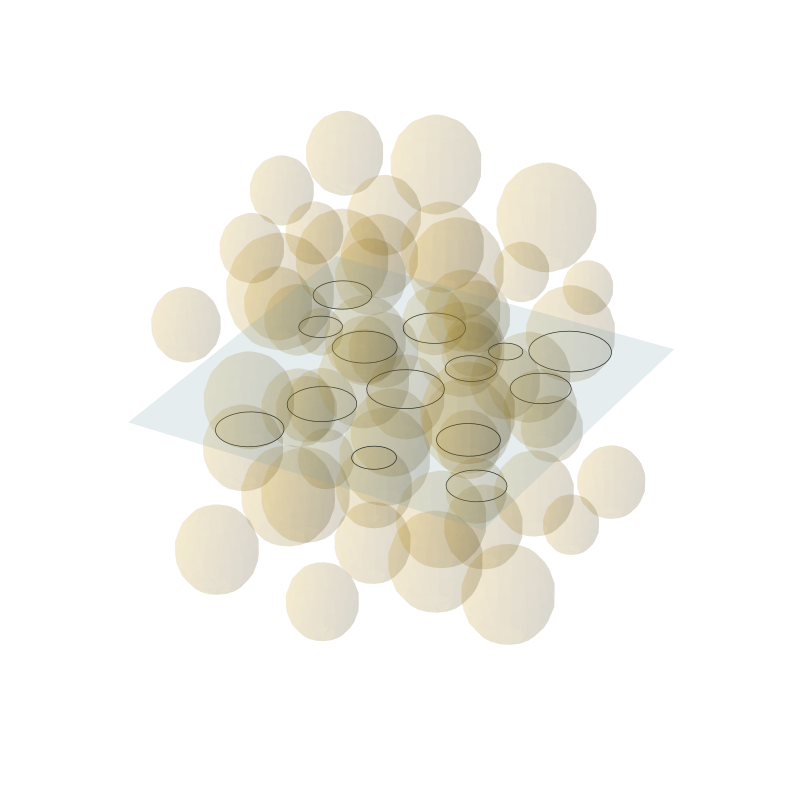

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import lognorm
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import art3d  # Correct import for pathpatch_2d_to_3d

# Parameters
cube_size = 10  # Size of the cube
num_spheres = 3000  # Increased number of spheres for dense packing
mean, sigma = 0.008, 0.2  # Smaller mean and moderate sigma for smaller varied spheres

# Generate log-normal distributed sphere radii
radii = lognorm.rvs(sigma, scale=np.exp(mean), size=num_spheres)

# Initialize list to store positions and ensure no overlaps
sphere_positions = []
max_attempts = 50000  # High limit for non-overlapping attempt loop in dense setup

# Function to check overlap
def check_overlap(new_pos, new_radius, positions, radii):
    for pos, radius in zip(positions, radii):
        dist = np.linalg.norm(new_pos - pos)
        if dist < (new_radius + radius):  # Check for overlap
            return True
    return False

# Generate non-overlapping sphere positions
attempts = 0
for radius in radii:
    while attempts < max_attempts:
        new_pos = np.random.uniform(radius, cube_size - radius, 3)
        if not check_overlap(new_pos, radius, sphere_positions, radii[:len(sphere_positions)]):
            sphere_positions.append(new_pos)
            break
        attempts += 1

# Limit the number of spheres to those that fit without overlapping
sphere_positions = np.array(sphere_positions[:num_spheres])
radii = radii[:len(sphere_positions)]

# Create the plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1, 1, 1])

# Plot each smaller sphere with high density in a darker yellow
for pos, radius in zip(sphere_positions, radii):
    u, v = np.mgrid[0:2 * np.pi:20j, 0:np.pi:10j]
    x = radius * np.cos(u) * np.sin(v) + pos[0]
    y = radius * np.sin(u) * np.sin(v) + pos[1]
    z = radius * np.cos(v) + pos[2]
    ax.plot_surface(x, y, z, color="#d4a017", alpha=0.1)  # Darker yellow shade for spheres

# Define a cutting plane perpendicular to the z-axis in light blue
plane_z = cube_size / 2
xx, yy = np.meshgrid(np.linspace(0, cube_size, 20), np.linspace(0, cube_size, 20))
zz = np.full_like(xx, plane_z)
ax.plot_surface(xx, yy, zz, color='lightblue', alpha=0.2)  # Light blue for the plane

# Calculate and plot intersection circles
for pos, radius in zip(sphere_positions, radii):
    # Check if the sphere intersects the plane
    distance_to_plane = abs(pos[2] - plane_z)
    if distance_to_plane < radius:  # There is an intersection
        # Calculate the radius of the intersection circle
        intersection_radius = np.sqrt(radius**2 - distance_to_plane**2)
        # Plot the circle on the plane
        circle = Circle((pos[0], pos[1]), intersection_radius, color="black", fill=False, linewidth=0.5)
        ax.add_patch(circle)
        art3d.pathpatch_2d_to_3d(circle, z=plane_z, zdir="z")

# Remove the axes and any additional frame
ax.set_axis_off()

plt.show()

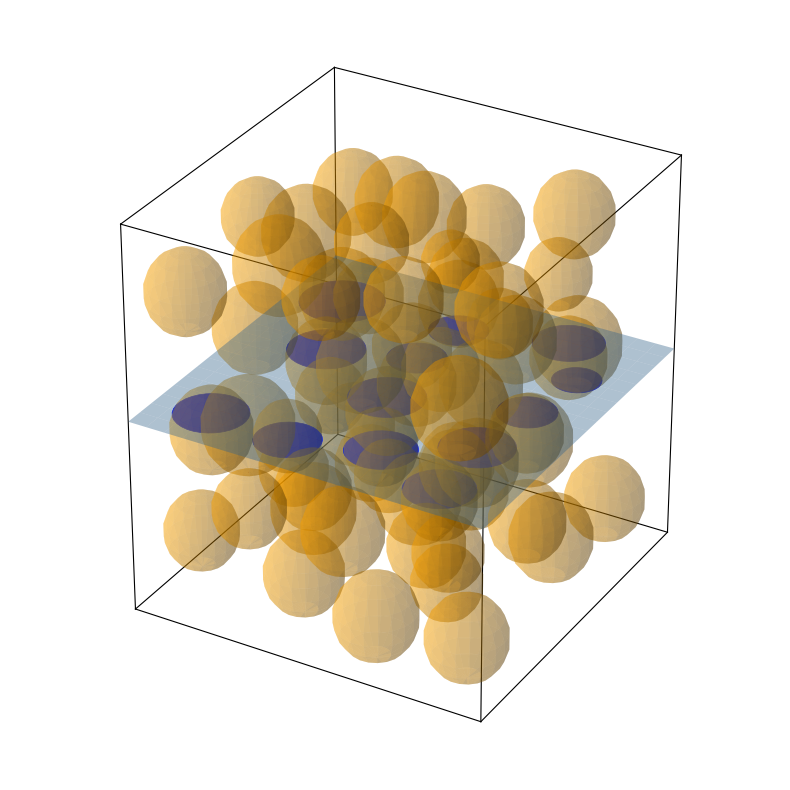

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import lognorm
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import art3d  # Correct import for pathpatch_2d_to_3d

# Parameters
cube_size = 10  # Size of the cube
num_spheres = 4500  # Increased number of spheres for dense packing with smaller size
mean, sigma = 0.0016, 0.1  # Smaller mean and moderate sigma for varied smaller spheres

# Generate log-normal distributed sphere radii
radii = lognorm.rvs(sigma, scale=np.exp(mean), size=num_spheres)

# Initialize list to store positions and ensure no overlaps
sphere_positions = []
max_attempts = 150000  # High limit for non-overlapping attempt loop in dense setup

# Function to check overlap
def check_overlap(new_pos, new_radius, positions, radii):
    for pos, radius in zip(positions, radii):
        dist = np.linalg.norm(new_pos - pos)
        if dist < (new_radius + radius):  # Check for overlap
            return True
    return False

# Generate non-overlapping sphere positions
attempts = 0
for radius in radii:
    while attempts < max_attempts:
        new_pos = np.random.uniform(radius, cube_size - radius, 3)
        if not check_overlap(new_pos, radius, sphere_positions, radii[:len(sphere_positions)]):
            sphere_positions.append(new_pos)
            break
        attempts += 1

# Limit the number of spheres to those that fit without overlapping
sphere_positions = np.array(sphere_positions[:num_spheres])
radii = radii[:len(sphere_positions)]

# Create the plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1, 1, 1])

# Plot each smaller sphere with high density in brownish color
for pos, radius in zip(sphere_positions, radii):
    u, v = np.mgrid[0:2 * np.pi:20j, 0:np.pi:10j]
    x = radius * np.cos(u) * np.sin(v) + pos[0]
    y = radius * np.sin(u) * np.sin(v) + pos[1]
    z = radius * np.cos(v) + pos[2]
    ax.plot_surface(x, y, z, color="orange", alpha=0.3)  # Brownish shade for spheres
    # ax.plot_surface(x, y, z, color="#8B4513", alpha=0.1)  # Brownish shade for spheres

# Define a cutting plane perpendicular to the z-axis in a slightly darker blue
plane_z = cube_size / 2
xx, yy = np.meshgrid(np.linspace(0, cube_size, 20), np.linspace(0, cube_size, 20))
zz = np.full_like(xx, plane_z)
ax.plot_surface(xx, yy, zz, color='#4682B4', alpha=0.4)  # Darker blue for the plane

# Calculate and plot filled intersection circles in darker gray
for pos, radius in zip(sphere_positions, radii):
    # Check if the sphere intersects the plane
    distance_to_plane = abs(pos[2] - plane_z)
    if distance_to_plane < radius:  # There is an intersection
        # Calculate the radius of the intersection circle
        intersection_radius = np.sqrt(radius**2 - distance_to_plane**2)
        # Plot the filled circle on the plane in darker gray
        circle = Circle((pos[0], pos[1]), intersection_radius, color="blue", fill=True, linewidth=0.5)
        ax.add_patch(circle)
        art3d.pathpatch_2d_to_3d(circle, z=plane_z, zdir="z")

# Draw the edges of the cube
cube_edges = [
    # Bottom edges
    [(0, 0, 0), (cube_size, 0, 0)],
    [(cube_size, 0, 0), (cube_size, cube_size, 0)],
    [(cube_size, cube_size, 0), (0, cube_size, 0)],
    [(0, cube_size, 0), (0, 0, 0)],
    # Top edges
    [(0, 0, cube_size), (cube_size, 0, cube_size)],
    [(cube_size, 0, cube_size), (cube_size, cube_size, cube_size)],
    [(cube_size, cube_size, cube_size), (0, cube_size, cube_size)],
    [(0, cube_size, cube_size), (0, 0, cube_size)],
    # Vertical edges
    [(0, 0, 0), (0, 0, cube_size)],
    [(cube_size, 0, 0), (cube_size, 0, cube_size)],
    [(cube_size, cube_size, 0), (cube_size, cube_size, cube_size)],
    [(0, cube_size, 0), (0, cube_size, cube_size)]
]
for edge in cube_edges:
    ax.plot(*zip(*edge), color="black", linewidth=0.8)

# Remove the axes and any additional frame
ax.set_axis_off()

# Save the figure as Fig. 2.pdf
plt.savefig("Fig. 2 cube.pdf", format="pdf")

# Show the figure
plt.show()